In [73]:
from langgraph.graph import MessagesState

In [74]:
def node_a(state: MessagesState):
    return {"messages": ["data 1"]}

def node_b(state: MessagesState):
    return {"messages": ["data 2"]}

def node_c(state: MessagesState):
    return {"messages": ["data 3"]}

def node_d(state: MessagesState):
    return {"messages": ["data 4"]}

In [75]:
from langgraph.graph import StateGraph, START, END

In [76]:
graph = (
    StateGraph(MessagesState)

    .add_node("a", node_a)
    .add_node("b", node_b)
    .add_node("c", node_c)
    .add_node("d", node_d)

    .add_edge(START, "a")
    .add_edge("a", "b")
    .add_edge("a", "c")
    .add_edge("b", "d")
    .add_edge("c", "d")
    .add_edge("d", END)

    .compile()
)

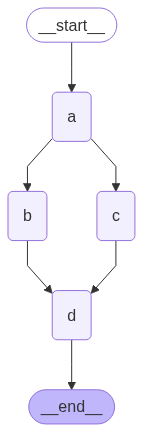

In [77]:
from IPython.display import Image, display
diagram = Image(graph.get_graph().draw_mermaid_png())

display(diagram)

In [78]:
out = graph.invoke(
    {
        "messages":[]
    }
)

In [79]:
for msg in out["messages"]:
    msg.pretty_print()

================================ Human Message =================================

data 1
================================ Human Message =================================

data 2
================================ Human Message =================================

data 3
================================ Human Message =================================

data 4


## ROUTING

In [80]:
from dotenv import load_dotenv

In [81]:
load_dotenv()

True

In [82]:
from langchain_openai import ChatOpenAI

In [83]:
model = ChatOpenAI(
    model_name="gpt-4o-mini"
)

In [84]:
from typing import Annotated, TypedDict

In [85]:
class State(TypedDict):
    review: str
    sentiment: str
    response: str

In [86]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda
from langchain_core.output_parsers import StrOutputParser

In [87]:
prompt_sentiment = ChatPromptTemplate.from_messages(
    [
        (
            "system", "You are a helpful assistant",
        ),
        (
            "human", "Classify the sentiment of this customer's product review as positive, negative, or neutral: {review}. You must answer either positice and negative and neutral"
        )
    ]
)

In [88]:
task_lowercase = RunnableLambda(lambda text: text.lower())

In [89]:
task_sentiment = (
    prompt_sentiment
    |model
    | StrOutputParser()
    | task_lowercase
)

In [90]:
def node_sentiment_analysis(state : State):
    review = state["review"]
    sentiment = task_sentiment.invoke(review)
    return{
        "sentiment" : sentiment
    }

In [91]:
system_msg = "You are a customer representative who reads customer's review and respond to their product review"

In [92]:
def node_positive_writer(state: State):
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",system_msg,
            ),
            (
                "human", "Generate a thank-you note for this positive review: {review}."
            )
        ]
    )
    chain = (
        prompt
        | model
        | StrOutputParser()
    )
    result = chain.invoke(
        {
            "review" : state["review"]
        }
    )
    return{
        "response" : result
    }

In [93]:
def node_negative_writer(state: State):
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",system_msg,
            ),
            (
                "human", "Generate a response addressing this negative review: {review}. Ask if the customer wants a refund. a replacement"
            )
        ]
    )
    chain = (
        prompt
        | model
        | StrOutputParser()
    )
    result = chain.invoke(
        {
            "review" : state["review"]
        }
    )
    return{
        "response" : result
    }

In [94]:
def node_neutral_writer(state: State):
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",system_msg,
            ),
            (
                "human", "Generate a request for more details for this neutral review: {review}. Ask what needs to be done to make the product better"
            )
        ]
    )
    chain = (
        prompt
        | model
        | StrOutputParser()
    )
    result = chain.invoke(
        {
            "review" : state["review"]
        }
    )
    return{
        "response" : result
    }

### conditional Edge

In [95]:
from typing import Literal

In [96]:
def node_which_writer(state : State) -> Literal["node_positive_writer","node_negative_writer","node_neutral_writer"]:
    sentiment = state["sentiment"]
    if sentiment == "positive":
        return "node_positive_writer"
    elif sentiment == "negative":
        return "node_negative_writer"
    elif sentiment == "neutral":
        return "node_neutral_writer"

In [97]:
from langgraph.graph import StateGraph, START, END

In [98]:
graph = (
    StateGraph(State)
    .add_node("node_sentiment_analysis",node_sentiment_analysis)
    .add_node("node_positive_writer",node_positive_writer)
    .add_node("node_negative_writer",node_negative_writer)
    .add_node("node_neutral_writer", node_neutral_writer)

    .add_edge(START, "node_sentiment_analysis")
    .add_edge("node_positive_writer",END)
    .add_edge("node_negative_writer",END)
    .add_edge("node_neutral_writer",END)
    .add_conditional_edges("node_sentiment_analysis",node_which_writer)

    .compile()
)

In [99]:
from IPython.display import display, Image

In [100]:
diagram = Image(
    graph.get_graph().draw_mermaid_png()
)

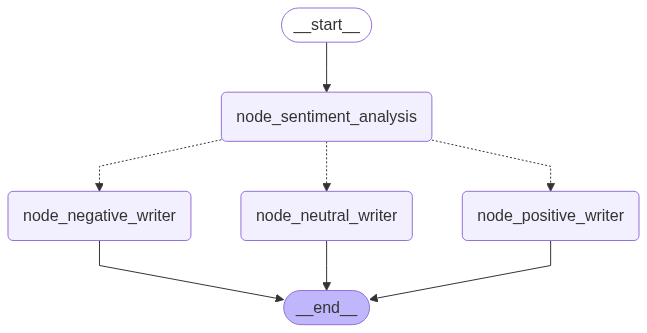

In [101]:
display(diagram)

In [102]:
state = graph.invoke(
    {
        "review" : "This product is really awesome!"
    }
)

In [103]:
state

{'review': 'This product is really awesome!',
 'sentiment': 'positive',
 'response': 'Dear Valued Customer,\n\nThank you so much for your wonderful review! We are thrilled to hear that you find our product awesome. Your support and feedback mean a lot to us, and it motivates us to continue delivering the best for our customers. If you have any questions or need assistance in the future, please feel free to reach out. \n\nThanks again, and happy using!\n\nBest regards,  \n[Your Name]  \nCustomer Support Team'}

In [104]:
print(state["response"])

Dear Valued Customer,

Thank you so much for your wonderful review! We are thrilled to hear that you find our product awesome. Your support and feedback mean a lot to us, and it motivates us to continue delivering the best for our customers. If you have any questions or need assistance in the future, please feel free to reach out. 

Thanks again, and happy using!

Best regards,  
[Your Name]  
Customer Support Team


In [105]:
state = graph.invoke(
    {
        "review" : "This produict no langer works after only one use!"
    }
)

In [106]:
print(state["response"])

Dear [Customer's Name],

Thank you for sharing your feedback with us. I'm really sorry to hear that the product stopped working after just one use. We strive to provide quality products, and it's disappointing to know that we didn't meet your expectations this time.

To resolve this issue, we would be happy to offer you a refund or a replacement, whichever you prefer. Please let us know what works best for you, and we'll ensure it's taken care of promptly.

We appreciate your understanding, and we hope to make this right for you.

Best regards,  
[Your Name]  
Customer Support Team
